Zuclopenthixol is an antipsychotic used for schizophrenia and other types psychoses. In the UK, there are two injecatable forms available
 - Zuclopenthixol **acetate** : a short acting treatment used for acute episodes 
 - Zuclopenthixol **decanoate** : a long acting treatment used for maintenance
 
 The [BNF has a safety warning](https://bnf.nice.org.uk/drug/zuclopenthixol-acetate.html) on both medicines advising that **acetate** preparartions are used in hospitals in acute epeisodes while **deconate** preparations are used in the community. The implcation being that **acetate** should not be prescribed in primary care.
 
 Initial analysis of the ANalyse page reports [30,398 items for **Decanoate**](https://openprescribing.net/analyse/#org=CCG&numIds=0402020Z0&denom=nothing&selectedTab=summary) and [61 items for **acetate**](https://openprescribing.net/analyse/#org=CCG&numIds=040201010&denom=total_list_size&selectedTab=summary) in the last 12 months. We have been told that quite often **acetate** is prescribed in error in primary care and really if it should not be prescribed it should not be available on the picking list. This notebook aims to see if there are any differences between EHRs

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(items) as total_items,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practice_statistics AS prac
ON
rx.practice = prac.practice AND prac.month = rx.month
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND Date = rx.month
JOIN
  hscic.practices as practices
ON
  practices.code = software.ODS
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND (bnf_code LIKE "040201010%" OR ##acetate
  bnf_code LIKE "0402020Z0%") ##Decanoate
GROUP BY
rx.month,
supplier,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_zuclo = bq.cached_read(sql, csv_path='zuclo.csv')
df_zuclo['month'] = df_zuclo['month'].astype('datetime64[ns]')
df_zuclo.head(3)

,month,supplier,practice,pct,chemical_code,chemical,total_items,total_cost
0,2016-01-01,EMIS,P81100,01A,0402020Z0,Zuclopenthixol Decanoate,4,77.85
1,2016-01-01,TPP,A86036,13T,0402020Z0,Zuclopenthixol Decanoate,2,57.75
2,2016-01-01,Unknown,P83019,00V,0402020Z0,Zuclopenthixol Decanoate,3,14.88


In [3]:
##here we check the BNF name to see if products included look correct and no coding changes.
df_zuclo["chemical"].unique()

array(['Zuclopenthixol Decanoate', 'Zuclopenthixol Acetate'], dtype=object)

In [4]:
df_decan = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Decanoate"]
df_decan.head()

,month,supplier,practice,pct,chemical_code,chemical,total_items,total_cost
0,2016-01-01,EMIS,P81100,01A,0402020Z0,Zuclopenthixol Decanoate,4,77.85
1,2016-01-01,TPP,A86036,13T,0402020Z0,Zuclopenthixol Decanoate,2,57.75
2,2016-01-01,Unknown,P83019,00V,0402020Z0,Zuclopenthixol Decanoate,3,14.88
3,2016-01-01,EMIS,F84083,08V,0402020Z0,Zuclopenthixol Decanoate,1,5.93
4,2016-01-01,TPP,E81007,06F,0402020Z0,Zuclopenthixol Decanoate,2,11.64


In [5]:
df_acetate = df_zuclo.loc[df_zuclo["chemical"] == "Zuclopenthixol Acetate"]
df_acetate.head()


,month,supplier,practice,pct,chemical_code,chemical,total_items,total_cost
209,2016-01-01,EMIS,F81018,06T,040201010,Zuclopenthixol Acetate,1,9.05
265,2016-01-01,TPP,L84046,11M,040201010,Zuclopenthixol Acetate,1,44.73
776,2016-01-01,EMIS,M88007,05L,040201010,Zuclopenthixol Acetate,1,35.89
782,2016-01-01,EMIS,M92024,06A,040201010,Zuclopenthixol Acetate,1,22.37
1130,2016-01-01,EMIS,K81651,15A,040201010,Zuclopenthixol Acetate,2,18.11


In [6]:
df = df_acetate.groupby(['month','supplier'])['total_items'].sum().reset_index()
df.head(10)

,month,supplier,total_items
0,2016-01-01,EMIS,6
1,2016-01-01,TPP,1
2,2016-02-01,EMIS,7
3,2016-02-01,TPP,2
4,2016-03-01,EMIS,9
5,2016-03-01,TPP,2
6,2016-04-01,EMIS,9
7,2016-04-01,TPP,1
8,2016-05-01,EMIS,10
9,2016-05-01,TPP,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
month          84 non-null datetime64[ns]
supplier       84 non-null object
total_items    84 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.0+ KB


Text(0.5,1,'Zuclopenthixol Acetate, total items per supplier')

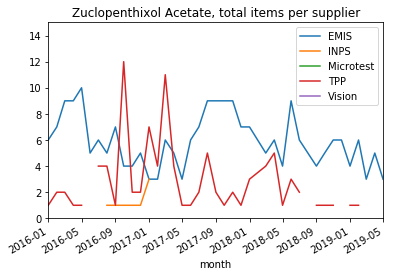

In [8]:
df_acetate.groupby(['month', 'supplier']).sum()['total_items'].unstack().plot.line()
plt.legend(loc='best')
plt.ylim(0, 15)
plt.title("Zuclopenthixol Acetate, total items per supplier")

Text(0.5,1,'Zuclopenthixol Decanoate, total items per supplier')

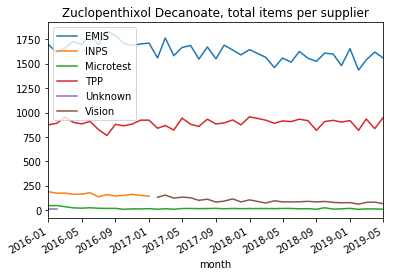

In [9]:
df_decan.groupby(['month', 'supplier']).sum()['total_items'].unstack().plot.line()
plt.legend(loc='upper left')
plt.title("Zuclopenthixol Decanoate, total items per supplier")

There is a lot more prescribing of Zuclopenthixol in EMIS systems overall. Need to chat to the team.

An alert of Acetate prescribing may be useful but it is limited as it will be retrospective. It might be similar to Nimodipine?